In [1]:
import os
import copy
from __future__ import print_function

#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 
import pyreadr
import scipy.io as sio
from itertools import combinations
from sklearn.model_selection import train_test_split

#Probabilistic programs
#!pip install pymc3
#!pip install pymc==4.0.0b1
import pymc3 as pm
#import pymc as pm
#import aesara.tensor as at
import theano.tensor as tt 
from theano.compile.ops import as_op
print('Running on PyMC v{}'.format(pm.__version__))

#!pip install HDDM Bayesian drift diffussion
import hddm #WARNING: from hddm 0.9 onward works (pip install cython pip install pymc pip install git+https://github.com/hddm-devs/kabuki pip install git+https://github.com/hddm-devs/hddm )
print ("hddm version: ", hddm.__version__)

#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az
import colorsys

# Image processing stuff
#!pip install opencv-python
import cv2

#User-defined functions (in the same folder as the notebook)
import my_fun as mf

Running on PyMC v3.11.4
HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
hddm version:  0.9.2


In [ ]:
#https://github.com/hddm-devs/hddm/blob/master/src/wfpt.pyx
#https://github.com/hddm-devs/hddm/blob/master/src/pdf.pxi #This one has the method and implementation of Navarro & Fuss, 2009
#https://github.com/hddm-devs/hddm/blob/master/src/cdfdif.c

# Decision criterion

Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

## Drift diffusion

Enigma & Turing [recomended video](https://www.youtube.com/watch?v=G2_Q9FoD-oQ) <br><br>


<center><img src="img/9_CB/DDM1.png" width = "801" height = '800'></center>

The code was probabilistic (pseudo-uniform, the Germans never used the same letter in the code and the message) IF the position of the rotors was not known

<center><img src="img/9_CB/DDM2.png" width = "601" height = '600'></center>

The machines were similar in how they produced random codes (mechanical system with rotors in initial positions; similar to random seeds today) <br> <br>

<center><img src="img/9_CB/DDM5.png" width = "701" height = '700'></center>

If two intercepted codes shared a letter in the same position it was likely to be the same machine/rotor position. <br><br>

<center><img src="img/9_CB/DDM3.png" width = "501" height = '500'></center>

We can accumulate noisy information up to a threshold to decide if they are indeed the same machine (upper threshold) or different (lower threshold) and start decoding <br><br>

<center><img src="img/9_CB/DDM4.png" width = "501" height = '500'></center>

What does this have to do with Bayesian cognition and decisions?

Brain activity is noisy. Before deciding, LIP accumulates MT activity up to a threshold to confirm <br><br>

<center><img src="img/9_CB/DDM6.svg" width = "701" height = '700'></center>
Roitman & Shadlen (2002)

The usual parameters are drift rate, bound levels, starting point, and non-decision times.<br>
In many versions of the DDM (not all), the likelihood ratio is accumulated (assumes uniform prior): $\frac{p(evidence|decision \ 1)}{p(evidence|decision \ 2)}$ <br>
In other versions, a decision variable is accumulated that can be inferred given the actions and response times <br><br>


<center><img src="img/9_CB/DDM7.svg" width = "801" height = '800'></center>
Shadlen & Kiani (2002)

What is the brightest red? <br><br><br>
<center><img src="img/9_CB/DDM8.svg" width = "501" height = '500'></center>
<br><br><br>

What is the brightest red? <br><br><br>
<center><img src="img/9_CB/DDM9.svg" width = "501" height = '500'></center>
<br><br><br>

What is the brightest red? <br><br><br>
<center><img src="img/9_CB/DDM10.svg" width = "501" height = '500'></center>
<br><br><br>

In which turn were you slowest? In that turn the evidence accumulated slower (other parameters constant)

The evidence accumulation framework has been applied in (reviews in Ratcliff, et al, 2016; Shadlen & Kiani, 2013):

* Numerosity
* Memory
* Perception of movement
* Language
* Categorization
* Marketing
* Altruism
* Intertemporal discount
* Others

There are several algorithms to estimate the model parameters (Table of Shinn, et al, 2020). Here we focus on HDDM which is Bayesian (Wiecki, et al, 2013). <br><br>

<center><img src="img/9_CB/DDM11.svg" width = "601" height = '600'></center>

v: drift rate <br>
a: decision threshold <br>
z: starting point of accumulation <br>
ndt: non-decision times (e.g. encoding) <br>
$s_v, \ s_z, \ s_{ndt}$: inter-trial variability of parameters <br>
x: response time and choice <br>


<center><img src="img/9_CB/model_HDDM.svg" width = "601" height = '600'></center>

We are going to use the HDDM package (Wiecki, Sofer, and Frank, 2013) and the demo at http://ski.clps.brown.edu/hddm_docs/tutorial_python.html

The package is based on PyMC. However, it requires special density definitions for $x_{ji}$ so we use HDDM for ease of life.

We will use data from Cavanagh, et al, (2011). Subthalamic nucleus stimulation reverses mediofrontal influence over decision threshold.

<center><img src="img/9_CB/Cav1.png" width = "601" height = '600'></center>

4 items. A: wins 100%; B: 0%; C: 75%; D: 25%. Odds of winning are learned through trial and error <br>
4 trial types:
* High conflict WW win-win (A vs C); 
* High conflict LL lose-lose (B vs D); 
* Low-conflict WL (A vs D; C vs B). 

Hypothesis: High conflict trials increase the threshold level.

In [2]:
data = hddm.load_csv('data/9_CB/HDDM_data.csv')
data

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
...,...,...,...,...,...,...,...
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC


Let's see subject's data

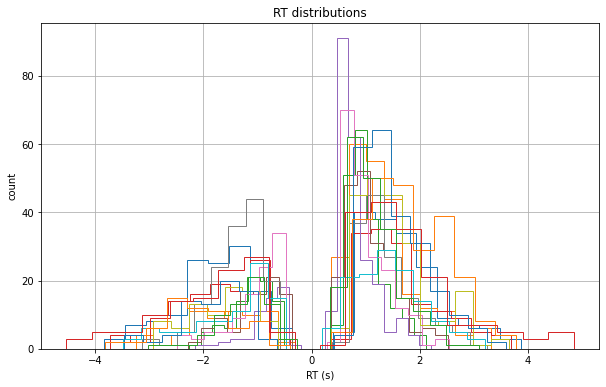

In [3]:
data = hddm.utils.flip_errors(data) #puts error response times in negative.

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)



Now fit the simplest model where the parameters do not vary by condition

In [4]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
#m = hddm.HDDM(data, include=('z', 'sv', 'st', 'sz')) #If you want to include inter-trial variability. SLOW
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 98.3 sec

Now let's see the threshold group parameter ($\mu_a$) and its variability ($\sigma_a$), and its value for one subject ($a_1$)

In [5]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0'])]


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97441,0.0943483,1.79436,1.91184,1.97052,2.03479,2.17431,0.00238907
a_std,0.341506,0.085328,0.222372,0.28487,0.326275,0.378211,0.552952,0.00283126
a_subj.0,2.19873,0.0659363,2.07629,2.15314,2.19851,2.24331,2.32462,0.00184475


Plotting a
Plotting a_std
Plotting v
Plotting t


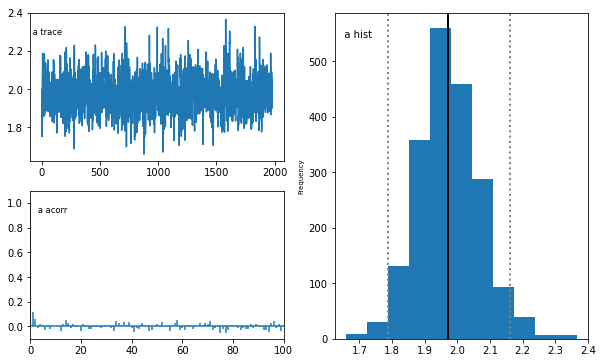

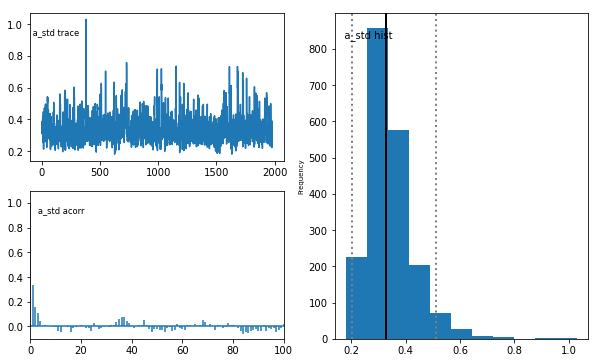

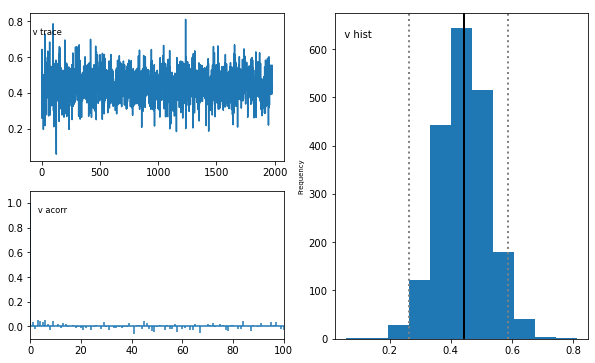

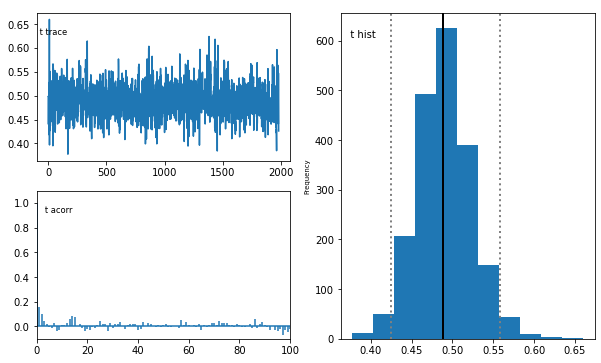

In [6]:
#Now the plot of the traces, autocorrelations (if they go to zero it indicates good sampling), and histograms of some parameters
m.plot_posteriors(['a', 't', 'v', 'a_std']) #group level parameters

To run several strings you have to run the command several times. With several strings, rhat (<1.1 convergence) can be computed.

In [7]:
models = []
nchains = 4
for i in range(nchains): 
    print("Cadena: ", i)
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models) #rhat<1.1 convergio

Cadena:  0
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 246.4 secCadena:  1
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 248.4 secCadena:  2
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 245.3 secCadena:  3
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 247.5 sec

{'a': 0.9999433743078823,
 'a_std': 1.0000496653757884,
 'a_subj.0': 1.0004208652746833,
 'a_subj.1': 0.9999045461202273,
 'a_subj.2': 1.0006126630053986,
 'a_subj.3': 1.0000631354367022,
 'a_subj.4': 1.0005655791845047,
 'a_subj.5': 0.9999221833812636,
 'a_subj.6': 0.9999074051503969,
 'a_subj.7': 1.000054456604566,
 'a_subj.8': 1.0000722316890716,
 'a_subj.9': 1.0000152012462102,
 'a_subj.10': 1.0003508728721082,
 'a_subj.11': 1.0009282718751737,
 'a_subj.12': 1.0005490693488528,
 'a_subj.13': 1.00001661188105,
 'v': 1.0001743084163879,
 'v_std': 1.0001190547640082,
 'v_subj.0': 0.9999956218011533,
 'v_subj.1': 1.000046778976248,
 'v_subj.2': 1.0000825447001582,
 'v_subj.3': 0.9999610464235583,
 'v_subj.4': 1.000271130688843,
 'v_subj.5': 1.0003661506500938,
 'v_subj.6': 1.000035599688013,
 'v_subj.7': 1.000036045813774,
 'v_subj.8': 0.9999528434507704,
 'v_subj.9': 0.99995777439972,
 'v_subj.10': 1.000386613752258,
 'v_subj.11': 1.0002196832367727,
 'v_subj.12': 1.0000518543539976,


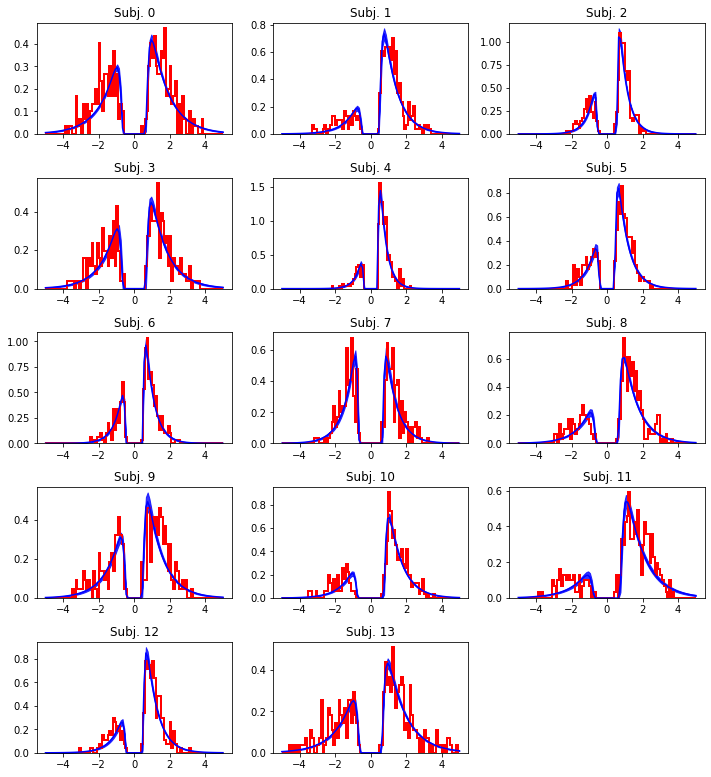

In [8]:
#Plot posterior predictive (red data, blue model) (HDDM plot_posterior_predictive function was not working)
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        #if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
        #    continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]
        
def _plot_posterior_pdf_node(bottom_node, axis, value_range=None, samples=10, bins=100):
    """Calculate posterior predictive for a certain bottom node.
    :Arguments:
        bottom_node : pymc.stochastic
            Bottom node to compute posterior over. Bottom refers to individual level parameters.
        axis : matplotlib.axis
            Axis to plot into.
        value_range : numpy.ndarray
            Range over which to evaluate the likelihood.
    :Optional:
        samples : int (default=10)
            Number of posterior samples to use.
        bins : int (default=100)
            Number of bins to compute histogram over.
    """

    if value_range is None:
        # Infer from data by finding the min and max from the nodes
        #raise NotImplementedError("value_range keyword argument must be supplied.")
        value_range = np.linspace(-5, 5, 100) #in seconds

    like = np.empty((samples, len(value_range)), dtype=np.float32)
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node) #this obtains random parameters (a, v, ndt)
        # IMPORTANT ONE: Generate likelihood 
        like[sample,:] = bottom_node.pdf(value_range) #Basically, this is Navarro & Fuss (2009) likelihood

    y = like.mean(axis=0) #The mean of the posterior predictive
    try:
        y_std = like.std(axis=0)
    except FloatingPointError:
        print("WARNING! %s threw FloatingPointError over std computation. Setting to 0 and continuing." % bottom_node.__name__)
        y_std = np.zeros_like(y)

    # Plot pp
    axis.plot(value_range, y, label='post pred', color='b')
    axis.fill_between(value_range, y-y_std, y+y_std, color='b', alpha=.8)

    # Plot data
    if len(bottom_node.value) != 0:
        axis.hist(bottom_node.value.values, density=True, color='r',
                  range=(value_range[0], value_range[-1]), label='data',
                  bins=bins, histtype='step', lw=2.)

    axis.set_ylim(bottom=0) # Likelihood and histogram can only be positive


observeds = m.get_observeds()
max_items = max([len(i[1]) for i in observeds.groupby('tag').groups.items()])
columns = min(3, max_items)
num_subjs = observeds.shape[0]
for tag, nodes in observeds.groupby('tag'): #nodes are parameters e.g. bottom-node is a non-group level parameter
    fig = plt.figure(figsize=(10,30))
    #fig.suptitle(tag, fontsize=12)
    fig.subplots_adjust(top=0.9, hspace=.4, wspace=.3)

    nrows = num_subjs or len(nodes)/columns

    if len(nodes) - int(nrows * columns) > 0:
        nrows += 1

    # Plot individual subjects (if present)
    i = 0
    for subj_i, (node_name, bottom_node) in enumerate(nodes.iterrows()):
        i += 1
        
        ax = fig.add_subplot(int(np.ceil(nrows)), int(columns), int(subj_i+1))
        if 'subj_idx' in bottom_node:
            ax.set_title('Subj. ' + str(bottom_node['subj_idx']))

        _plot_posterior_pdf_node(bottom_node['node'], ax)

        if i >= np.ceil(nrows) * columns:
            warnings.warn('Too many nodes. Consider increasing number of columns.')
            break

        if num_subjs is not None and i >= num_subjs:
            break
    plt.tight_layout()

With HDDM we can calculate parameters by condition (WW, LL, WL) using the depends_on option.

In [9]:
m_stim = hddm.HDDM(data, depends_on={'v': 'stim', 'a': 'stim'}) # en depends_on, el value del diccionario es la columna en la data con la condición experimental
m_stim.find_starting_values()
m_stim.sample(4500, burn=1000)

#the sampled parameters are in .nodes_db.node. It is a pandas dataframe
v_WW, v_LL, v_WL = m_stim.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
a_WW, a_LL, a_WL = m_stim.nodes_db.node[['a(WW)', 'a(LL)', 'a(WL)']]
ndt = m_stim.nodes_db.node['t']

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 4500 of 4500 complete in 389.8 sec

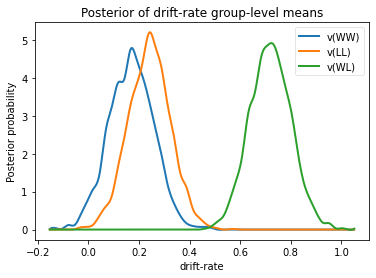

<Figure size 432x288 with 0 Axes>

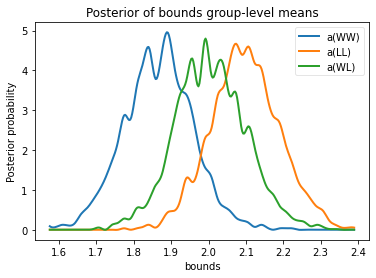

<Figure size 432x288 with 0 Axes>

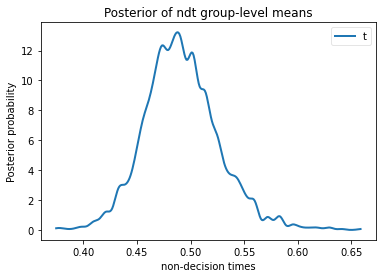

In [10]:
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL]);
plt.xlabel('drift-rate');
plt.ylabel('Posterior probability');
plt.title('Posterior of drift-rate group-level means');

plt.figure();
hddm.analyze.plot_posterior_nodes([a_WW, a_LL, a_WL]);
plt.xlabel('bounds');
plt.ylabel('Posterior probability');
plt.title('Posterior of bounds group-level means');


plt.figure();
hddm.analyze.plot_posterior_nodes([ndt]);
plt.xlabel('non-decision times');
plt.ylabel('Posterior probability');
plt.title('Posterior of ndt group-level means');


In [11]:
#Model comparison via DIC (lower is better)
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

Lumped model DIC: 10973.197308
Stimulus model DIC: 10766.317699


The HDDM package can also calculate the parameters with external information via regressions (e.g. that the drift depends on age or brain activity). Details at https://github.com/hddm-devs/hddm

The HDDM package does not simulate, it uses formulas, however let's see approximately a simulation to obtain the decision variable (the trace). This can be useful, for example, to calculate confidence in the decision.
<br><br>
<center><img src="img/9_CB/Wiecki1.svg" width = "601" height = '600'></center>
Imagen: Wiecki, et al, 2013

40.10173806257447 0.7137231241932557 0.49224384076677846 -2.2892318659151227 [-2.28923187 -3.05365066 -2.7603434  ... 46.52907511 44.94050698
 45.07675486]
0.007137231241932557 992 992 correct


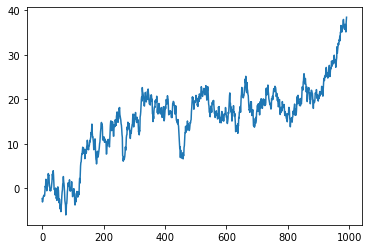

In [13]:
#Simulated DV (decision variable)
a = 20*a_WL.trace().mean() # bound
v = v_WL.trace().mean() # drift
t = ndt.trace().mean() # non-decision time
n_ttrrials = 200
sampling_rate = 1e-2 #arbitrary units 

#simulated_data, params = hddm.generate.gen_rand_data(params={'a': a, 'v': v, 't': t}, size=n_ttrrials) #No se estimo st, sv, sz
#print([simulated_data['rt'].mean() - t, simulated_data['response'].mean(), v,a,t])

z = np.random.uniform(-a/4,a/4)#Starting point
DVdt = np.append(np.array([z]), np.random.normal(v*sampling_rate, 1, 3000))
DV = np.cumsum(DVdt)
print(a, v, t, z, DV)
idx_below = np.argmax(DV<-a) #bottom threshold
idx_above = np.argmax(DV>a) #upper threshold
if min(idx_below, idx_above) == 0:
    idx_choice_time = max(idx_below, idx_above)
else:
    idx_choice_time = min(idx_below, idx_above)
choicee = 'correct'
if idx_choice_time==0: #never passed a threshold
    choicee = 'No threshold hit'
    idx_choice_time = len(DV)-1
elif idx_choice_time == idx_below: 
    choicee = 'wrong'
    
    
DV = DV[0:idx_choice_time]
#DV = DV[(DV<(a*sampling_rate)) & (DV>(-a*sampling_rate))]
plt.plot(DV);
print(v*sampling_rate, DV.shape[0], idx_choice_time, choicee)
#DV


Let us define confidence as p(choice=correct|DV). Let's implement this idea in an exercise.

# Exercise 

* Simulate the DV of a correct turn and infer the probability that the DV is greater than zero. That is, assume your data is the vector DV and you want to calculate if the posterior of the average DV is greater than zero. Use a normal likelihood and a uniform prior for the mean and standard deviation of the DV (remember that the standard deviation must be greater than zero i.e. the prior goes from [0, K]).
     * Bonus: do it two ways, a) with pymc3 and b) with the formula for the density of a posterior with normal likelihood and uniform priors.

* Do the above (i.e. simulate the DV) for 5 WW turns, 5 LL turns, and 5 WL turns. Which condition generates more confidence?

* What happens if you lower the threshold? Do it only with WL trials.



# Appendix

In [ ]:
#Hierarchical Drift Diffusion Model (HDDM)
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Drift Diffusion Model (HDDM)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           mu_v -> v;\
           sigma_v -> v;\
           mu_a -> a;\
           sigma_a -> a;\
           mu_z -> z;\
           sigma_z -> z;\
           mu_ndt -> ndt;\
           sigma_ndt -> ndt;\
           v -> x;\
           a -> x;\
           z -> x;\
           ndt -> x;\
           sv -> x;\
           sz -> x;\
           sndt -> x;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$j subject$";\
               v;\
               a;\
               z;\
               ndt;\
               subgraph cluster1 {\
                   margin = 5; labeljust=l; lblstyle="font=\\small";\
                   style = rounded;\
                   label = "$i trial$";\
                   x;\
               }\
           }\
           /* nodes */\
           v [label = "$v_j$", shape = circle];\
           mu_v [label = "$mu_v$", shape = circle];\
           sigma_v [label = "$sig_v$", shape = circle];\
           a [label = "$a_j$", shape = circle];\
           mu_a [label = "$mu_a$", shape = circle];\
           sigma_a [label = "$sig_a$", shape = circle];\
           z [label = "$z_j$", shape = circle];\
           mu_z [label = "$mu_z$", shape = circle];\
           sigma_z [label = "$sig_z$", shape = circle];\
           ndt [label = "$ndt_j$", shape = circle];\
           mu_ndt [label = "$mu_{ndt}$", shape = circle];\
           sigma_ndt [label = "$sig_{ndt}$", shape = circle];\
           sv [label = "$s_v$", shape = circle];\
           sz [label = "$s_z$", shape = circle];\
           sndt [label = "$s_{ndt}$", shape = circle];\
           x [label = "$x_{ji}$", fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_HDDM.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#distributions:
# \mu_v \sim Normal(2,3)
# \sigma_v \sim Half \ Normal(0,2)
# \mu_a \sim Normal(1.5,0.75)
# \sigma_a \sim Half \ Normal(0,0.1)
# \mu_z \sim Normal(0.5,0.5)
# \sigma_z \sim Half \ Normal(0,0.05)
# \mu_{ndt} \sim Normal(0.4,0.2)
# \sigma_{ndt} \sim Half \ Normal(0,1)
# s_v \sim Half \ Normal(0,2)
# s_z \sim Beta(1,3)
# s_{ndt} \sim Half \ Normal(0,0.3)
# a_j \sim \Gamma(\mu_a, \sigma_a^2)
# v_j \sim Normal(\mu_v, \sigma_v^2)
# z_j \sim invlogit(Normal(\mu_z, \sigma_z^2))
# ndt_j \sim Normal(\mu_{ndt}, \sigma_{ndt}^2)
# x_{ji} \sim \frac{\pi}{a_j^2} e^{\left( -v_j a_j z_j - \frac{v_j^2x}{2} \right)} \times \sum_{k=1}^{\infty} k e^{\left(-\frac{k^2\pi^2x}{2a_j^2}\right)} sin(k \pi z_j)


#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}

In [ ]:
#Signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i data sets$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_SDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#d_i \sim Normal(0, \frac{1}{2})
#c_i \sim Normal(0,2)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)



In [ ]:
# Hierarchical signal detection theory
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Hierarchical Signal Detection Theory (SDT)";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.3, width=0.3, lblstyle="font=\\small"];\
           /* links */\
           lambda_c -> c;\
           mu_c -> c;\
           lambda_d -> d;\
           mu_d -> d;\
           c -> theta_h;\
           c -> theta_f;\
           d -> theta_h;\
           d -> theta_f;\
           theta_f -> f;\
           theta_h -> h;\
           s -> h;\
           n -> f;\
           subgraph cluster0 {\
               margin = 5; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i people$";\
               c;\
               d;\
               s;\
               n;\
               h;\
               f;\
               theta_f;\
               theta_h;\
           }\
           /* nodes */\
           lambda_c [label = "$lam_c$", shape = circle];\
           lambda_d [label = "$lam_d$", shape = circle];\
           mu_c [label = "$mu_c$", shape = circle];\
           mu_d [label = "$mu_d$", shape = circle];\
           c [label = "$c_i$", shape = circle];\
           d [label = "$d_i$", shape = circle];\
           s [label = "$s_i$", fillcolor = gray, style = filled, shape = square];\
           n [label = "$n_i$", fillcolor = gray, style = filled, shape = square];\
           h [label = "$h_i$", fillcolor = gray, style = filled, shape = square];\
           f [label = "$f_i$", fillcolor = gray, style = filled, shape = square];\
           theta_f [label = "$theta_i^f$", shape = circle, peripheries = 2];\
           theta_h [label = "$theta_i^h$", shape = circle, peripheries = 2];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/9_CB/model_hSDT.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#\mu_c, \ \mu_d \sim Normal(0,0.001)
#\lambda_c, \ \lambda_d \sim Normal(0.001,0.001)
#d_i \sim Normal(\mu_d, \lambda_d)
#c_i \sim Normal(\mu_c, \lambda_c)
#\theta_i^h = \Phi(\frac{1}{2}d_i - c_i)
#\theta_i^f = \Phi(-\frac{1}{2}d_i - c_i)
#h_i \sim Binomial(\theta_i^h, s_i)
#f_i \sim Binomial(\theta_i^f, n_i)